In [1]:
using Revise
using DifferentialEquations
using Thyrosim
using DiffEqCallbacks
using DiffEqParamEstim
using SharedArrays
using Statistics
using Plots
using DelimitedFiles

## Plot T4 dose in ug/kg

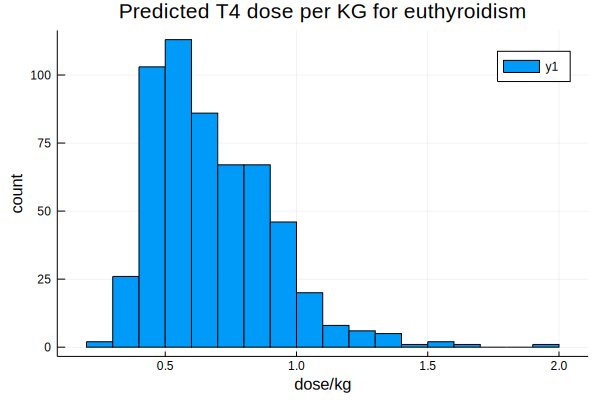

In [16]:
# import schneider data
train, test, toy = schneider_data()
all_schneider = [train; test]

# import predicted dosages: max-dose/avg-dose/min-dose
dosage_predicted = readdlm("schneider_dosage_prediction_result.txt")

# plot
dose_per_kg = all_schneider[!, Symbol("Wt.kg")] ./ dosage_predicted[:, 2]
histogram(dose_per_kg, title="Predicted T4 dose per KG for euthyroidism", 
            xlabel="dose/kg", ylabel="count")

## Check plots for those receiving wrong initial dose

Many patients received an initial dose too small for achieving euthyroidism. If we give them their initial dose, what is thyrosim's prediction?

In [45]:
# fitting index and fitting result
fitting_index = [5; 6; 28; 45; 30; 31; 49; 50; 51; 52; 53; 54]
initial_guess = [ 584.0; 1503.0; 0.8892067744277633;1.6882221360501146;69.90379778202167;38.71161774205076;
                 6.039888256864343; 3.7006563259936747;8.748185980217668;6.590694001313398;
                 2.896554559451672;13.013203952637502]
train_minimizer = [707.8452964855089, 1364.781337052841, 0.6130668479458289, 20.859423239660707, 
    14.65980760718759, 7.830316351504347, 0.0010539087239513961, 2.508839873001086, 
    75.82808292005706, 2.0954611542245636, 4.97949142853699e-5, 0.08705663474886477]

# define function for adding dose
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end

function compute_initial_dose_l2_error(sol, euthyroid_dose, initial_dose, Vtsh)
    tot_loss = 0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        tsh = sol.u[end][3] * 5.6 / Vtsh
        if euthyroid_dose > initial_dose && tsh < 4.5 #original TSH too high
            tot_loss += log(4.5 / tsh)
        elseif euthyroid_dose < initial_dose && tsh > 0.5 #original TSH too low
            tot_loss += log(tsh / 0.5)
        end
    end
    return tot_loss
end

height = SharedArray{Float64}(convert(Vector{Float64}, all_schneider[!, Symbol("Ht.m")]))
weight = SharedArray{Float64}(convert(Vector{Float64}, all_schneider[!, Symbol("Wt.kg")]))
sex    = SharedArray{Bool}(convert(Vector{Bool}, all_schneider[!, Symbol("Sex")]))
tspan  = SharedArray{Float64}(convert(Vector{Float64}, 24all_schneider[!, Symbol("Days.to.euthyroid")]))
init_tsh   = SharedArray{Float64}(convert(Vector{Float64}, all_schneider[!, Symbol("TSH.preop")]))
euthy_dose = SharedArray{Float64}(convert(Vector{Float64}, all_schneider[!, Symbol("LT4.euthyroid.dose")]))
init_dose  = SharedArray{Float64}(convert(Vector{Float64}, all_schneider[!, Symbol("LT4.initial.dose")]));

total = 3
i = 1 # counter
schneider_graphs = []
while length(schneider_graphs) < total
    euthyroid_dose = euthy_dose[i]
    initial_dose = init_dose[i]
    if initial_dose >= euthyroid_dose
        i += 1
        continue # only interested in those whose initial dose was not enough
    end

    #initialize simulation parameters
    h = height[i]
    w = weight[i]
    x = sex[i]
    t = tspan[i]
    initial_tsh = init_tsh[i]
    scale_Vp = true
    dial  = [0.0; 0.88; 0.0; 0.88]
    ic, p = initialize(dial, scale_Vp, h, w, x)
    ic[7] = initial_tsh
    tot_loss = zero(Int)
    cbk = PeriodicCallback(add_dose!, 24.0)# function to add dose

    # update parameter for fitting 
    p[fitting_index] .= train_minimizer
    error_contributed = compute_initial_dose_l2_error(sol, euthyroid_dose, initial_dose, p[48])
    
    println("patient $i height = $(round(h, digits=1)), weight = $(round(w, digits=0)), init dose = $initial_dose, euthy dose = $euthyroid_dose,")
    println("          initial dose/kg = $(round(initial_dose / w, digits=1)), euthy dose/kg = $(round(euthyroid_dose / w, digits=1))")
    println("          error = $error_contributed")
    p[55] = initial_dose / 777.0
    prob = ODEProblem(thyrosim,ic,(0.0, t),p,callback=cbk)
    sol = solve(prob)
    push!(schneider_graphs, output_plot(sol))
    
    i += 1
end
plot(schneider_graphs..., layout=(1, 3), size=(800, 500))

patient 2 height = 1.7, weight = 77.0, init dose = 125.0, euthy dose = 150.0,
          initial dose/kg = 1.6, euthy dose/kg = 1.9
          error = 1.2373706497758772
patient 3 height = 1.6, weight = 51.0, init dose = 100.0, euthy dose = 125.0,
          initial dose/kg = 1.9, euthy dose/kg = 2.4
          error = 1.2823019701639498
patient 15 height = 1.7, weight = 86.0, init dose = 150.0, euthy dose = 200.0,
          initial dose/kg = 1.7, euthy dose/kg = 2.3
          error = 1.7129267650189997


In [53]:
tot = 0
for i in 1:size(train, 1)
    euthyroid_dose = euthy_dose[i]
    initial_dose = init_dose[i]
    if initial_dose < euthyroid_dose
        tot += 1
    end
end
tot

91

In [54]:
tot / size(train, 1)

0.2275